In [1]:
import numpy as np

from scipy.stats import norm
from tqdm import tqdm

import time as t
import pickle

from plot_functions import *

# Load data

In [2]:
name = "NPE_C_maf_8_4"

In [3]:
global_params = np.array([[-2.3, -2.89], [0.3, 0.3]])

In [4]:
# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y

In [5]:
def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

In [6]:
# CHEMPY data with alternative yields
data_alternative_yields = np.load("data/chempy_data/chempy_alternative_yields.npz", mmap_mode='r')

elements = data_alternative_yields['elements']
alt_x = data_alternative_yields['params']
alt_y = data_alternative_yields['abundances']

alt_x, alt_y = clean_data(alt_x, alt_y)

# Remove H from data, because it is just used for normalization (output with index 2)
elements = np.delete(elements, 2)
alt_y = np.delete(alt_y, 2, 1)

alt_y_obs = add_noise(alt_y)[:200]

In [7]:
# TNG simulation data
data_tng = np.load("data/chempy_data_paper/Mock_Data_TNG.npz", mmap_mode='r')

tng_y = data_tng['true_abuns']

tng_y_obs = add_noise(tng_y)[:200]

# Load posterior

In [8]:
# ----- Load posterior -----
with open(f'data/posterior_{name}.pickle', 'rb') as f:
    posterior = pickle.load(f)

/export/home/bguenes/anaconda3/envs/sbi_chempy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Inference
### 1. Alternative yield set

In [9]:
alpha_IMF_alt_obs = []
log10_N_Ia_alt_obs = []
simulations = 1000
N_stars = len(alt_y_obs)

start = t.time()
for i in tqdm(range(len(alt_y_obs))):
    x = add_noise(alt_y_obs[i])
    alpha, N_Ia = posterior.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_alt_obs.append(alpha)
    log10_N_Ia_alt_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_alt_obs = np.array(alpha_IMF_alt_obs)
log10_N_Ia_alt_obs = np.array(log10_N_Ia_alt_obs)

100%|██████████| 200/200 [00:03<00:00, 50.33it/s]

Time to run 1000 simulations for 200 stars: 3.978 s


### 2. TNG simulation 

In [10]:
alpha_IMF_tng_obs = []
log10_N_Ia_tng_obs = []
simulations = 1000
N_stars = len(tng_y_obs)

start = t.time()
for i in tqdm(range(len(tng_y_obs))):
    x = add_noise(tng_y_obs[i])
    alpha, N_Ia = posterior.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_tng_obs.append(alpha)
    log10_N_Ia_tng_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_tng_obs = np.array(alpha_IMF_tng_obs)
log10_N_Ia_tng_obs = np.array(log10_N_Ia_tng_obs)

100%|██████████| 200/200 [00:04<00:00, 45.81it/s]

Time to run 1000 simulations for 200 stars: 4.368 s


# Plot

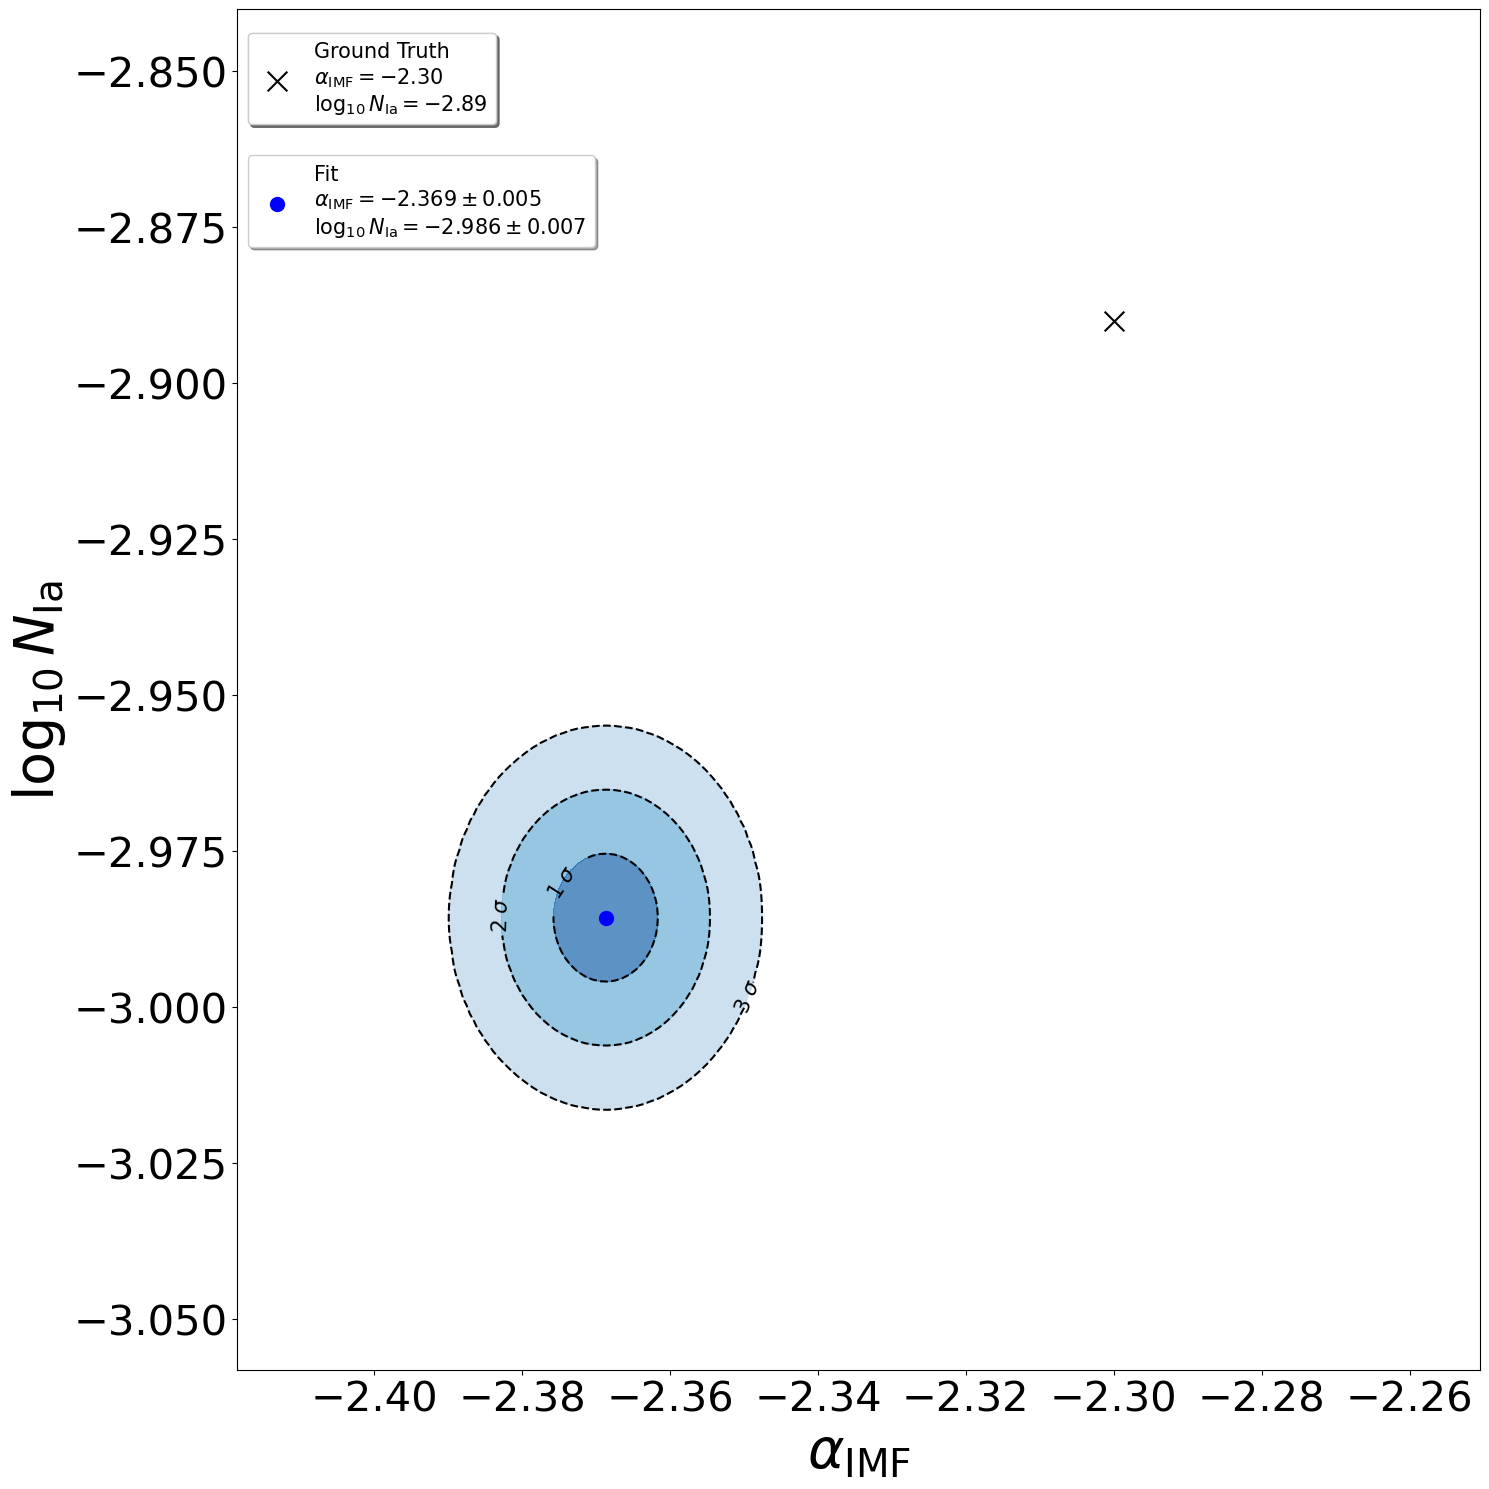

In [11]:
gaussian_posterior_plot(alpha_IMF_alt_obs, log10_N_Ia_alt_obs, global_params, title="CHEMPY alternative yields")

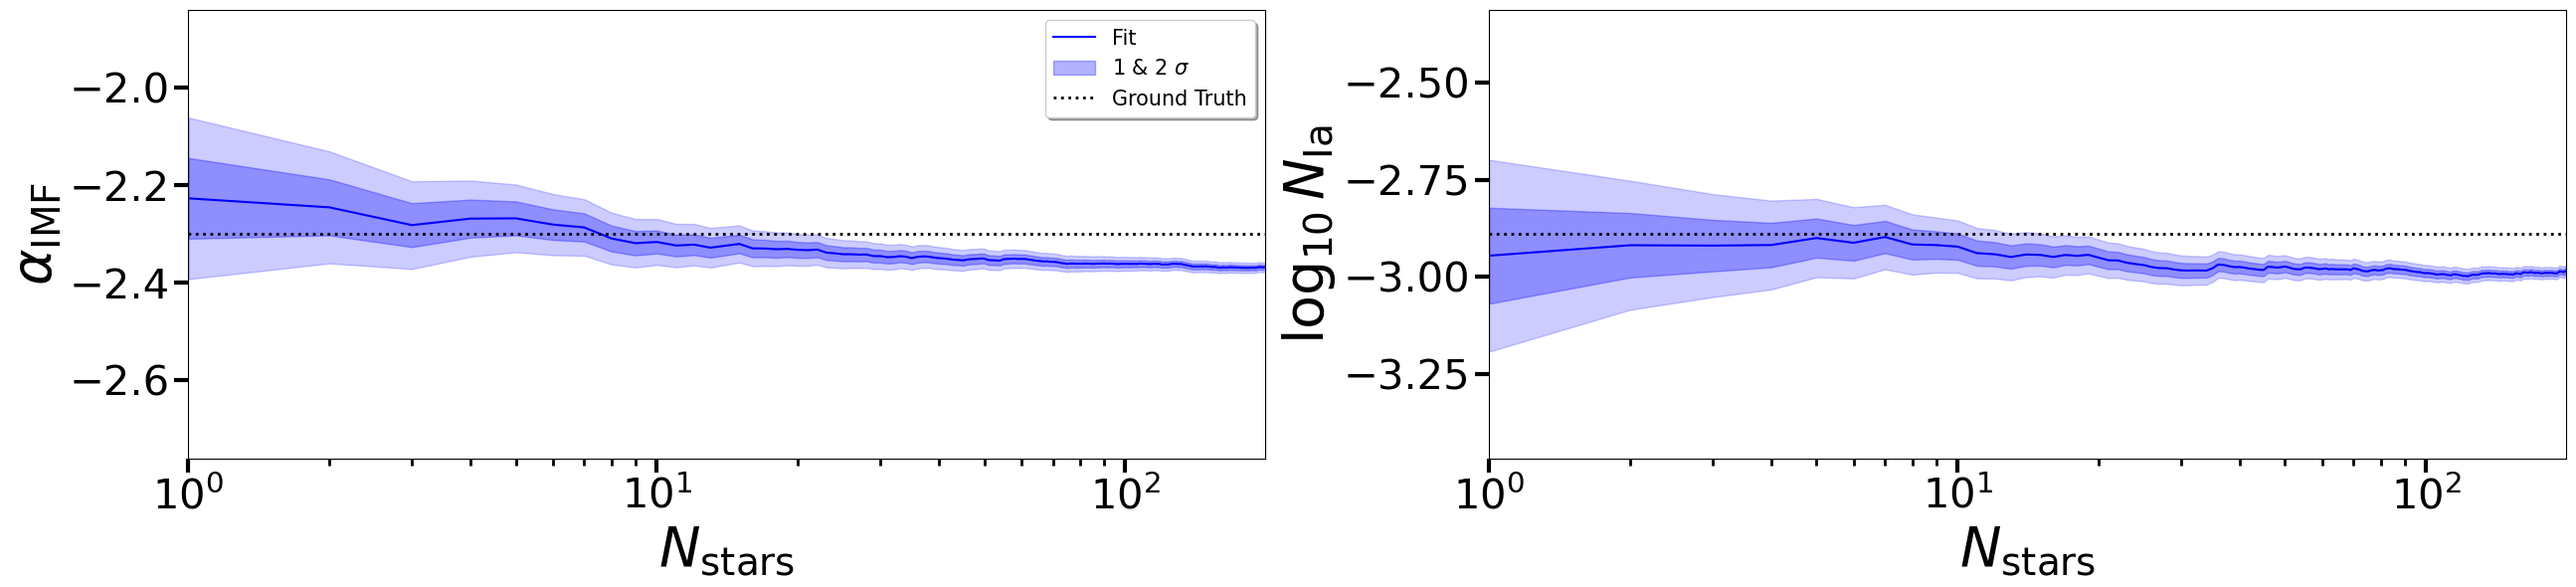

In [12]:
stars = np.arange(1,len(alt_y_obs))
n_stars_plot(alpha_IMF_alt_obs, log10_N_Ia_alt_obs, global_params, "CHEMPY alternative yields N_star", stars)

In [13]:
alpha_IMF_tng_obs = np.array(alpha_IMF_tng_obs)
log10_N_Ia_tng_obs = np.array(log10_N_Ia_tng_obs)

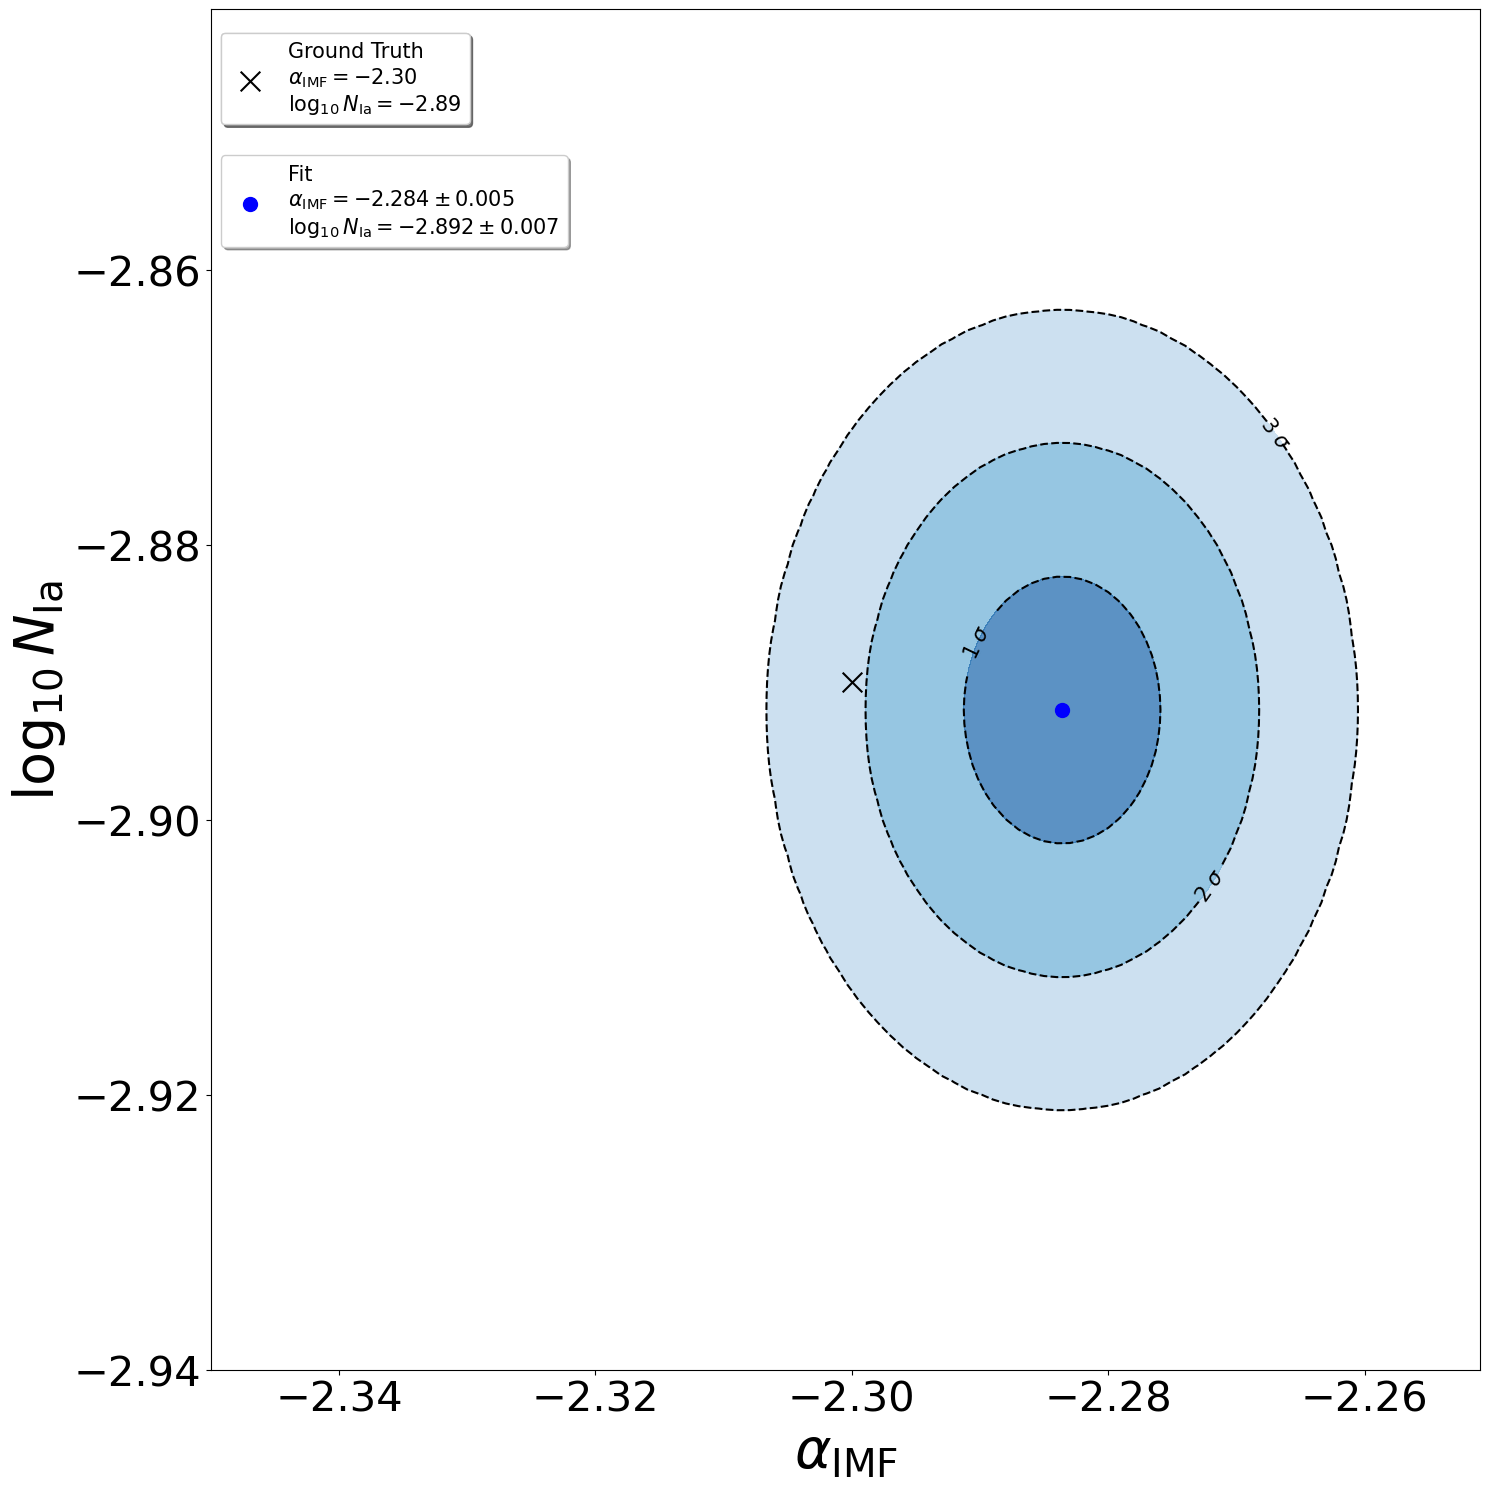

In [14]:
gaussian_posterior_plot(alpha_IMF_tng_obs, log10_N_Ia_tng_obs, global_params, title="TNG simulation")

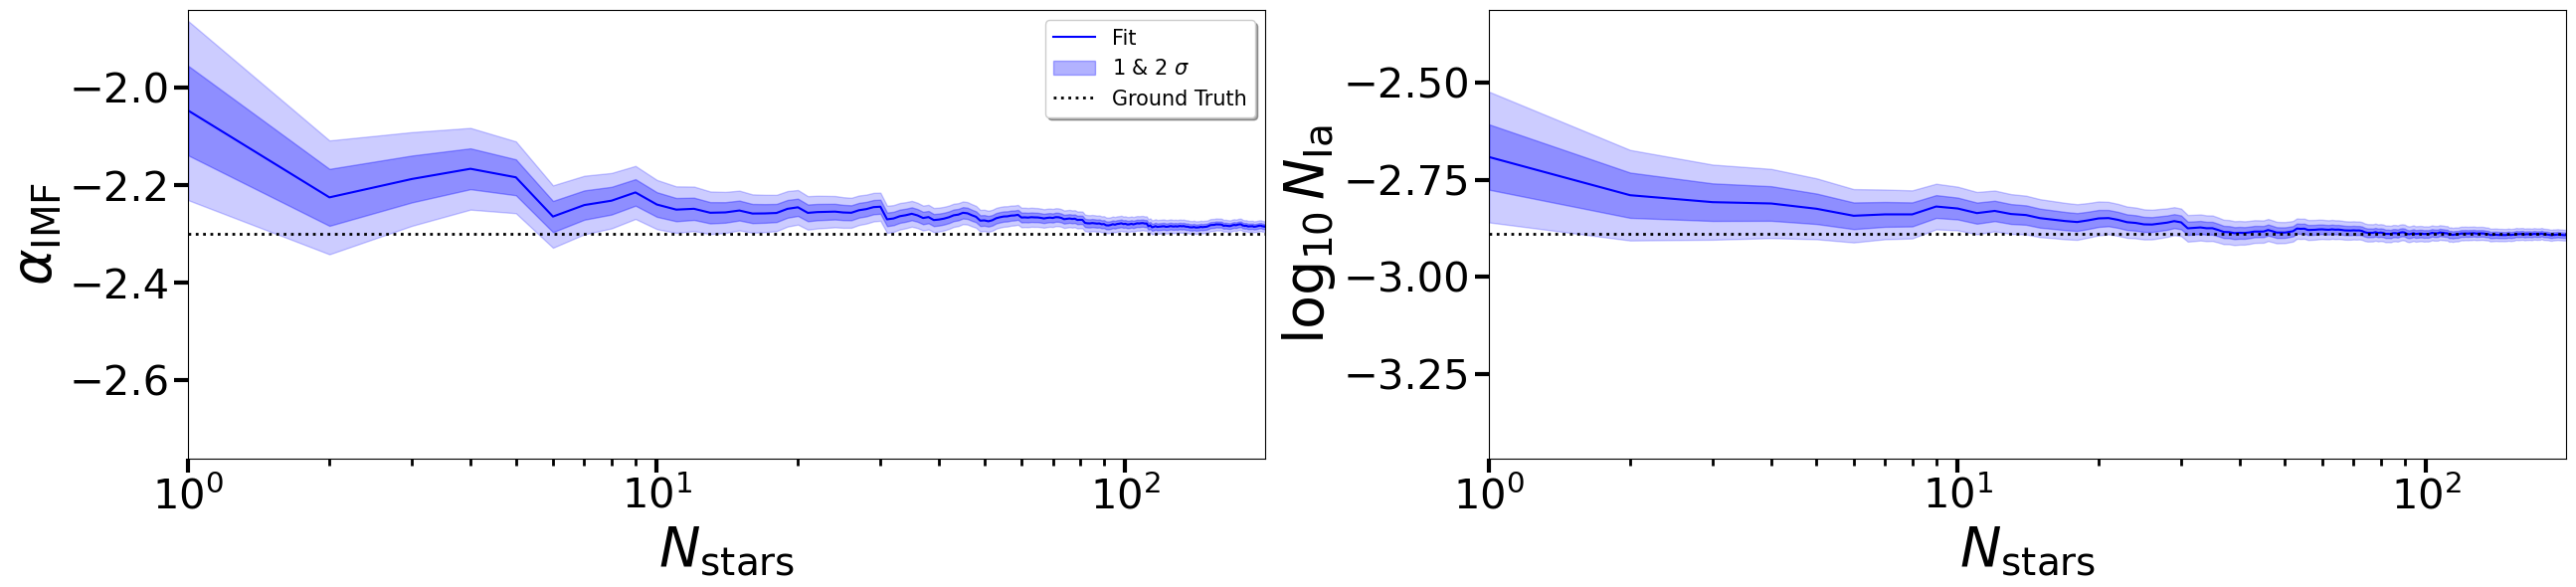

In [15]:
stars = np.arange(1,len(alpha_IMF_tng_obs))
n_stars_plot(alpha_IMF_tng_obs, log10_N_Ia_tng_obs, global_params, "TNG simulation N_star", stars)